In [6]:
!pip install gensim

     |████████████████████████████████| 24.0 MB 25 kB/s  eta 0:00:01


In [54]:
!pip install plotly

     |████████████████████████████████| 25.3 MB 2.3 MB/s eta 0:00:01    |████████████▋                   | 9.9 MB 2.7 MB/s eta 0:00:06     |████████████████████▎           | 16.0 MB 2.5 MB/s eta 0:00:04     |████████████████████████████▌   | 22.5 MB 2.0 MB/s eta 0:00:02     |███████████████████████████████▏| 24.7 MB 2.3 MB/s eta 0:00:01


In [6]:
from typing import List

In [7]:
import pandas as pd
import matplotlib
import re
import spacy
import os
from spacy.tokenizer import Tokenizer
from spacy.tokens import Doc

In [8]:
nlp_fr = spacy.load("fr_core_news_sm")

The file is way too big to open it with a regular notepad. But we still need to know how it was formatted in order to import it:

cpt=0
with open("openfoodfacts.csv") as f:
    for line in f:
        cpt+=1
        print(line)
        if cpt>5:
            break

This allows us to see that the delimiter is the '\t' special character

df = pd.read_csv("openfoodfacts.csv", encoding = 'utf-8', delimiter="\t")

df

print(df.columns)

na_counts = df.isna().sum()

dict(na_counts)

df.loc[df['code'] == 225]

Apply a condition on every entry of a column, then filter the dataframe using the boolean array:

%%time
df.loc[pd.Series(list(map(lambda f: "Prince Chocolat" in str(f), df['product_name'])))]

%%time
df.loc[df['product_name'].str.contains("Prince Chocolat", na=False)]

df["ingredients_text"].loc[14454]#.split(" ")

from collections import defaultdict
ingredients = defaultdict(int)
for ingr in df["ingredients_text"].dropna():
    for token in ingr.split(" "):
        ingredients[token] += 1
        
ingredients

packaging = defaultdict(int)
for ingr in df["packaging_text"].dropna():
    for token in ingr.split(" "):
        packaging[token] += 1
        
packaging

sorted(ingredients.items(), key=lambda k_v: k_v[1], reverse=True)

sorted(packaging.items(), key=lambda k_v: k_v[1], reverse=True)

df['countries_tags'].head(10)

countries_tags = defaultdict(int)
for product in df["countries_tags"].dropna():
    for country in product.split(","):
        countries_tags[country] += 1
        
countries_tags

fr_db_temp = df.loc[df['countries_tags'].str.contains("france", na=False)]
fr_db_temp

relevant_columns = ['code', 'product_name', 'ingredients_text', 'packaging_text']

fr_db= fr_db_temp.dropna(subset= ['ingredients_text', 'product_name']).filter(items= relevant_columns)
fr_db

ingredient_lists = list(fr_db['ingredients_text'])
ingredient_lists

def custom_tokenizer(nlp):
    
    
    special_cases = {":)": [{"ORTH": ":)"}]}
    prefix_re = re.compile(r'''^[\[\("']''')
    suffix_re = re.compile(r'''[\]\)"'\%]$''')
    infix_re = re.compile(r'''[-~]''')
    simple_url_re = re.compile(r'''^https?://''')
    
    return Tokenizer(nlp.vocab, rules=special_cases,
                                prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                url_match=simple_url_re.match)





nlp_fr = spacy.load("fr_core_news_sm")
nlp_fr.tokenizer = custom_tokenizer(nlp_fr)


my_str= u"PAIN BAGEL nature 44,2 % : farine de BLE, eau, huile végétale raffinée de colza, sucre, GLUTEN DE BLE, farine de MALT DE BLE, levure, sel, farine de SOJA, émulsifiants : E471, E322, agents de traitement de la farine : E300, E920. Garniture 55,8% : Aubergines grillées 41,4%, tomate 27.6%, FROMAGE FRAIS 13,8% (BABEURRE, CREME pasteurisée 13,3%, protéines de LAIT, acidifiant : acide citrique, sel, épaississant : farine de graines de caroube  conservateur : sorbate de potassium, arôme naturel), GRANA PADANO 13,8% (LAIT de vache cru, sel, présure, conservateur : lysozyme [protéine d'OEUF]), SAUCE PESTO 3,4% (huile de tournesol 42 %, basilic 29%, FROMAGES italiens 12,7% [grana padano, pecorino romano], farine de NOIX DE CAJOU, sel, BABEURRE en poudre/PIGNONS 9.8% fibres de BLE. acidifiant : acide lactique  antioxydant: acide ascorbique, ail). (% exprimés sur le garniture)"
doc = nlp_fr(my_str)
print([t.text for t in doc])
print(doc.char_span(18, 24))
indexes = [m.span() for m in re.finditer('[0-9]?[0-9] ?[,.]? ?[0-9]?[0-9]? ?%,?',my_str,flags=re.IGNORECASE)]
print(indexes)
for start, end in indexes:
    print(doc.char_span(start, end+1))
    print(doc.char_span(start, end))
    if doc.char_span(start, end):
        with doc.retokenize() as retokenizer:
            retokenizer.merge(doc.char_span(start, end))
    
print([t.text for t in doc])

def tokenize_ingredients(ingredient_lists: List[str]):
    nlp = spacy.load("fr_core_news_sm", disable= ['tagger', 'parser', 'ner', 'lemmatizer'])
    return list(nlp.pipe(ingredients))

tokenize_ingredients(ingredient_lists)

## Language detection

In [9]:
from langdetect import detect

In [10]:
def try_detect(text):
    try:
        language = detect(text)
    except:
        language = "error"
        print("This throws an error:", text)
    return language

fr_db['detected_lang'] = fr_db['ingredients_text'].apply(try_detect)

fr_db2 = fr_db.loc[fr_db['detected_lang'].str.contains("fr", na=False)]

In [11]:
fr_db2 = pd.read_csv('data/filtered_openfoodfacts.csv', sep = '\t')

In [12]:
fr_db2

,Unnamed: 0,code,product_name,ingredients_text,packaging_text,detected_lang
0,6,0000000000100,moutarde au moût de raisin,eau graines de téguments de moutarde vinaigre ...,NaN,fr
1,25,0000000001199,Solène céréales poulet,"antioxydant : érythorbate de sodium, colorant ...",NaN,fr
2,41,0000000002264,Baguette Poitevin,"baguette Poite vin Pain baguette 50,6%: farine...",NaN,fr
3,52,0000000003827,Suedois saumon,"Paln suédois 42,6%: farine de BLÉ, eau, farine...",NaN,fr
4,58,0000000004510,Salade shaker taboulé,"Taboulé 76,2%, légumes 12%, huile de colza, se...",NaN,fr
...,...,...,...,...,...,...
201107,1989475,99903336,Jus multifruits,Jus de fruits à base de jus concentrés et puré...,NaN,fr
201108,1989480,9991111111154,Compote à Boire Pomme Poire,"Pomme 71 %, poire 26 %, sucre 4%, antioxydant ...",NaN,fr
201109,1989483,99911522,Chipolatas,"Viande de porc 92%(origine France) eau,sel,aro...",NaN,fr
201110,1989531,9999200847366,Choco pearls,"sucre,beurre de cacao,poudre de jait.entier,fa...",NaN,fr


fr_db2.to_csv("filtered_openfoodfacts.csv", sep= "\t")

# Cleaning

In [13]:
RELEVANT_COLUMNS = ['code', 'product_name', 'ingredients_text', 'packaging_text']

def country_filter(df) -> pd.DataFrame:
    """Filters products which do not exist in France"""
    return df.loc[df['countries_tags'].str.contains("france", na=False)]

def na_filter(df) -> pd.DataFrame:
    """Filters products without an ingredient list"""
    return df.dropna(subset= ['ingredients_text', 'product_name']).filter(items=RELEVANT_COLUMNS)

# ~45 minutes on 250k entries
def detect_language(text: str) -> str:
    """Returns the language of the text. 'fr' for French"""
    try:
        language = detect(text)
    except:
        language = "error"
        # print("This throws an error:", text)
    return language

def language_filter(df) -> pd.DataFrame:
    """Filters products whose ingredient list is not in French"""
    df['detected_lang'] = df['ingredients_text'].apply(detect_language)
    return df.loc[df['detected_lang'].str.contains("fr", na=False)]

def filter_df(df) -> pd.DataFrame:
    """Applies all filters on the DataFrame"""
    df1 = country_filter(df)
    df2 = na_filter(df1)
    return language_filter(df2)

def read_data():
    df = pd.read_csv('en.openfoodfacts.org.products.csv', encoding = 'utf-8', delimiter="\t")
    return filter_df(df).to_csv("filtered_openfoodfacts.csv", sep= "\t") 

def compute_similarity(str1, str2) -> float:
    """Compute similarity ratio between two strings."""
    return ratio(str1, str2)

def remove_accent(accented_string) -> str:
    return unidecode.unidecode(accented_string)

def remove_special_char(noisy_string) -> str:
    """remove special characters from noisy strings."""
    return noisy_string.translate(str.maketrans("", "", "*•"))

def replace_char(noisy_string) -> str:
    return noisy_string.replace("_", " ")

def split_numbers(transaction_description) -> list:
    """This function separate the numbers and words if there is no space in between.
    Return a list containing the words and numbers of the transaction description """
    transaction_description_unglued = []
    for word in transaction_description:
        split = re.split(r'(\d+/?\d+)', word)
        transaction_description_unglued += split
    transaction_description_unglued = list(filter(lambda a: a != '' and a is not None,
                                                  transaction_description_unglued))
    return transaction_description_unglued

def remove_pourcentage(ingredient) -> list:
    """This function remove any pourcentage from a string"""
    return re.sub(r'(\d+( |.)?(\d+)?( )?%)', "", ingredient)

def preprocess_ingredient_list(ingredient_list) -> str:
    """Pre-processing Pipeline"""
    #ingredient_list = replace_slash(ingredient_list)
    ingredient_list = replace_char(ingredient_list.lower())
    #ingredient_list = remove_accent(ingredient_list)
    return remove_special_char(ingredient_list)

def parse_ingredient(data, index) -> pd.DataFrame:
    """This is a function to extract 'root ingredients' from ingredient lists.
    A 'root ingredient' is defined as a basic component of an item 
    (similar to a factor in mathematics)"""
    columns = ["ingredient", "subingredient_1", "subingredient_2", "root_ingredient"]
    new_data = pd.DataFrame(columns=columns)
    ingredient = ''
    subingredient_1 = ''
    subingredient_2 = ''
    paren_count = 0
    last_delimiter = ''
    to_append = pd.DataFrame(columns=columns)
    for token in data:
        #print(str(token))
        #print()
        if str(token) in ['(', '[', ':']:
            last_delimiter = str(token)
            paren_count = paren_count + 1
        elif (str(token) in [')', ']']) or (str(token) in [','] and last_delimiter == ':'):
            last_delimiter = str(token)
            paren_count = paren_count - 1
            
        if str(token) in ['%', ]:
            if paren_count == 0:
                ingredient = ingredient + ' ' + str(token)
            elif paren_count == 1:   
                subingredient_1 = subingredient_1 + ' ' + str(token)
            elif paren_count == 2:
                subingredient_2 = subingredient_2 + ' ' + str(token) 
                
            if (ingredient != '') | (subingredient_1 != '') | (subingredient_2 != ''):
                new_data=new_data.append(to_append)
                to_append = pd.DataFrame({'ingredient': ingredient.strip(), 
                                          'subingredient_1': subingredient_1.strip(),
                                          'subingredient_2': subingredient_2.strip()},
                                         index=[index])
            if paren_count == 0:
                ingredient = ''
                subingredient_1 = ''
                subingredient_2 = ''
            elif paren_count == 1:
                subingredient_1 = ''
                subingredient_2 = ''
            elif paren_count == 2:
                subingredient_2 = ''
            
        elif str(token) not in ['(', ')', '[', ']', ',', ':', '.']:
            if paren_count == 0:
                ingredient = ingredient + ' ' + str(token)
            elif paren_count == 1:   
                subingredient_1 = subingredient_1 + ' ' + str(token)
            elif paren_count == 2:
                subingredient_2 = subingredient_2 + ' ' + str(token)        

        elif str(token) in [',', ':', '.']:
            #print(str(token))
            #print(ingredient)
            #print(subingredient_1)
            #print(subingredient_2)
            
            if (ingredient != '') | (subingredient_1 != '') | (subingredient_2 != ''):
                new_data=new_data.append(to_append)
                to_append = pd.DataFrame({'ingredient': ingredient.strip(), 
                                          'subingredient_1': subingredient_1.strip(),
                                          'subingredient_2': subingredient_2.strip()},
                                         index=[index])
            if paren_count == 0:
                ingredient = ''
                subingredient_1 = ''
                subingredient_2 = ''
            elif paren_count == 1:
                subingredient_1 = ''
                subingredient_2 = ''
            elif paren_count == 2:
                subingredient_2 = ''

    return new_data
    
def parse_ingredients(ingredients_dataframe) -> pd.DataFrame:
    new_data = pd.DataFrame()
    ingredients_dataframe["tokenized"] = [nlp_fr(preprocess_ingredient_list(text)) for text in ingredients_dataframe.ingredients]
    for i in range(len(ingredients_dataframe)):
        new_data = new_data.append(parse_ingredient(ingredients_dataframe.tokenized[i], i))
    return new_data

def parse_ingredients_test() -> pd.DataFrame:
    """Unit test"""
    data = pd.DataFrame(
    ["""45 % massepain (44% amandes, sucre, sirop de glucose et de fructose, eau), farine de blé, 10 % de raisins secs, 10% beurre, dextrose, sucre, 2% amandes, levure, œuf entier*, sel de cuisine, graisse de palme, amidon de blé. *d'élevage au sol. Peut contenir traces des arachides, de soja et des autres fruits à coque. 
     Conserver à l'abri de la chaleur et au sec.""",
     """BRIOCHE TRANCHÉE AU BEURRE ET À LA CRÉME FRAÏCHE Farine de blé française 53%, 
     sucre, beurre pâtissier 8%, œufs entiers frais 7.5%, eau, crème fraîche française 3.2%, 
     sirop de sucre inverti, sel, ez/ uten de blé, levure, arômes naturels (contient ainol), 
     émulsifiant (E471), protéines de lait, levwe désactivée, colorant (béta carotène).""", 
     """antioxydant : érythorbate de sodium, colorant : caramel - origine UE), 
     tomate 33,3%, MAYONNAISE 11,1% (huile de colza 78,9%, eau, jaunes d'OEUF 6%, 
     vinaigre, MOUTARDE [eau, graines de MOUTARDE, sel, vinaigre, curcuma], sel, 
     dextrose, stabilisateur : gomme de cellulose, conservateur : sorbate de potassium, colorant : ?-carotène, arôme)""",
     """MAItSON GAUCHER chocolat de couverture noir 64% chocolat de couverture lait 38,2% amandes,
     noisettes, pistaches, noix, raisins, écorces d'oranges"""], 
    columns = ["ingredients"])
    return parse_ingredients(data)

def get_ingredients(ingredients_dataframe):
    ingredients_dataframe = parse_ingredients(ingredients_dataframe)
    ingredients = []
    for i in range(len(ingredients_dataframe)):
        if ingredients_dataframe.iloc[i]["subingredient_2"] != "":
            ingredient = remove_pourcentage(ingredients_dataframe.iloc[i]["subingredient_2"])
            if ingredient != "":
                ingredients.append(ingredient)
        elif ingredients_dataframe.iloc[i]["subingredient_1"] != "":
            ingredient = remove_pourcentage(ingredients_dataframe.iloc[i]["subingredient_1"])
            if ingredient != "":
                ingredients.append(ingredient)
        elif ingredients_dataframe.iloc[i]["ingredient"] != "":   
            ingredient = remove_pourcentage(ingredients_dataframe.iloc[i]["ingredient"])
            if ingredient != "":
                ingredients.append(ingredient)
    return ingredients

def correct_ingredients(misspelled):
    spell = SpellChecker(language='fr')
    misspelled = misspelled.split()
    correction = ""
    for word in misspelled:
        correction += ' ' + spell.correction(word)
        print("original word: "+ word)
        print("corrected word: "+ spell.correction(word))
    return correction

def correct_ingredients_test():
    misspelled = """Sucre, blanc d’oeufs frais, poudre d’amande, 16.5%, beurre co/centré, 
    farine de_blé, oeufs frais. sirop de glucose-fructose, 
    stabilsant : glycérol, sel, poudres à lever : carbonatesdesodium-diphosphates (blé), arôm."""
    return correct_ingredients(preprocess_ingredient_list(misspelled))

In [9]:
for i in range(50):
    print(preprocess_ingredient_list(fr_db2.iloc[i]['ingredients_text']), '\n')

eau graines de téguments de moutarde vinaigre de vin rouge sel vin rouge sucre   moût de raisin (6.2%) oignons colorants extraits de carotte et extrait de paprika huile de tournesol son de moutarde sel (cette  moutarde  uniquement disponible chez courte paille) 

antioxydant : érythorbate de sodium, colorant : caramel - origine ue), tomate 33,3%, mayonnaise 11,1% (huile de colza 78,9%, eau, jaunes d'oeuf 6%, vinaigre, moutarde [eau, graines de moutarde, sel, vinaigre, curcuma], sel, dextrose, stabilisateur : gomme de cellulose, conservateur : sorbate de potassium, colorant : ?-carotène, arôme) 

baguette poite vin pain baguette 50,6%: farine de blé, eau, sel, levure, gluten, farine de ble maité, levure désactivée, acide ascorbique, garniture fromage mi-chèvre 46% (lait pasteurisé [95 0% lait de vache, 5 0% lait de chèvre], sel, ferments lactiques et daffinage, coagulant), tomate saladg 20,4%, huile d'olive i basilic 1% 

paln suédois 42,6%: farine de blé, eau, farine de seigle, sucre, 

In [14]:
def remove_special_characters(text: str):
    text = text.translate(str.maketrans("", "", r"*•&\=+_~#²<>!?"))
    return text

In [15]:
def test_remove_special_characters():
    print(remove_special_characters("ndgn*dbs•z&\\\/=kvcxng+_sbdbfs~#²sbbs<sb> sbcdjbokdsc"))
    
test_remove_special_characters()

ndgndbsz/kvcxngsbdbfssbbssb sbcdjbokdsc


In [16]:
import unidecode
def remove_accent(accented_string) -> str:
    return unidecode.unidecode(accented_string)

In [17]:
INFIX_DELIMITERS = {
    ':': ' ', 
    '-': ' ', 
    ',': ' ', 
    ';':' ', 
    '.':' ', 
    "'": ' ',
    "/": ' ',
    "%": ' ',
    'œ': 'oe'}
def replace_infix(text):
    for delimiter in INFIX_DELIMITERS.keys():
        text = text.replace(delimiter, INFIX_DELIMITERS[delimiter])
    return text

In [18]:
def test_replace_infix():
    print(replace_infix("je mange des œufs-mimosas..."))
test_replace_infix()

je mange des oeufs mimosas   


In [19]:
def remove_percentage(text) -> list:
    """This function remove any percentage from a string"""
    return re.sub(r'(\d+( |.)?(\d+)?( )?%)', "", text)

In [20]:
def test_remove_percentage():
    print(remove_percentage("acide15.1%, nitrate15,1%, ammoniac 15.1%, levure 15,1%, banane 15.6 %, orange 20,8 %, fruit 25 %, cassis 15.7%ù kiwi 7815%, trucmuche 15 . 1 % autre 15 , 1 % jaipludinspi 15 . 1% gngn 15 , 1% "))
    
test_remove_percentage()

acide, nitrate, ammoniac , levure , banane , orange , fruit , cassis ù kiwi , trucmuche 15 .  autre 15 ,  jaipludinspi 15 .  gngn 15 ,  


In [21]:
def remove_numbers(tokens):
    return list(filter(lambda x: not x.isnumeric(), tokens))

In [22]:
def test_remove_numbers():
    print(remove_numbers("dfhdi 15 dijv 75 vjsoi 14.7, dijviv e205, dvov15, 14, 14,7    19, kd".split()))
test_remove_numbers()

['dfhdi', 'dijv', 'vjsoi', '14.7,', 'dijviv', 'e205,', 'dvov15,', '14,', '14,7', '19,', 'kd']


In [23]:
def flatten_tokens(tokens):
    flat_tokens = []
    for token in tokens:
        if type(token) == list:
            flat_tokens += token
        else:
            flat_tokens.append(token)
    return flat_tokens

In [24]:
PREFIX_DELIMITERS = ['(', '[']
SUFFIX_DELIMITERS = [')', ']', '.', ',', ';', ':']

def split_punct_prefix(tokens):
    for i in range(len(tokens)):
         if len(tokens[i]) > 1:   
            if tokens[i][0] in PREFIX_DELIMITERS:
                tokens[i] = [tokens[i][0], tokens[i][1:]]
    # print(tokens)
    return flatten_tokens(tokens)

def split_punct_suffix(tokens):
    # print("len:", len(tokens), "suffix:", tokens)
    for i in range(len(tokens)):
        # print(tokens[i])
        if len(tokens[i]) > 1:
            if tokens[i][-1] in SUFFIX_DELIMITERS:
                tokens[i] = [tokens[i][:-1], tokens[i][-1]]
    return flatten_tokens(tokens)

def split_puncts(tokens):
    return split_punct_suffix(split_punct_prefix(tokens))

split_puncts("hello, world! (hihi)".split())

['hello', ',', 'world!', '(', 'hihi', ')']

# Tokenization

In [25]:
def tokenizer(ingr: str):
    ingr1 = remove_special_characters(ingr.lower())
    ingr2 = remove_accent(ingr1)
    ingr3 = remove_percentage(ingr2)
    ingr4 = replace_infix(ingr3)
    ingr_list = remove_numbers(ingr4.split())
    ingr_list1 = list(filter(lambda tok: tok != '', ingr_list))
    # print("tokenizer:", ingr_list1)
    return split_puncts(ingr_list1)

In [26]:
from nltk.stem.snowball import SnowballStemmer
def tokenizer2(ingr: str):
    ingr = ingr.lower().translate(str.maketrans("", "", r"*•&\/=+_~#²<>!?{}()[]."))
    ingr = remove_accent(ingr)
    ingr = remove_percentage(ingr)
    ingr = replace_infix(ingr)
    toks = "".join(filter(lambda x: not x.isdigit(), ingr)).split()
    toks = list(filter(lambda tok: len(tok) > 2, toks))
    stemmer = SnowballStemmer(language = "french")
    return list(map(stemmer.stem, toks))

In [27]:
%%time
test_list = []
for i in range(len(fr_db2)):
    test_list.append(tokenizer2(fr_db2.iloc[i]['ingredients_text']))
    
test_list

CPU times: user 5min 12s, sys: 2.38 s, total: 5min 14s
Wall time: 6min 4s


[['eau',
  'grain',
  'tegu',
  'moutard',
  'vinaigr',
  'vin',
  'roug',
  'sel',
  'vin',
  'roug',
  'sucr',
  'mout',
  'raisin',
  'oignon',
  'color',
  'extrait',
  'carott',
  'extrait',
  'paprik',
  'huil',
  'tournesol',
  'son',
  'moutard',
  'sel',
  'cet',
  'moutard',
  'uniqu',
  'disponibl',
  'chez',
  'court',
  'paill'],
 ['antioxyd',
  'erythorbat',
  'sodium',
  'color',
  'caramel',
  'origin',
  'tomat',
  'mayonnais',
  'huil',
  'colz',
  'eau',
  'jaun',
  'oeuf',
  'vinaigr',
  'moutard',
  'eau',
  'grain',
  'moutard',
  'sel',
  'vinaigr',
  'curcum',
  'sel',
  'dextros',
  'stabilis',
  'gomm',
  'cellulos',
  'conserv',
  'sorbat',
  'potassium',
  'color',
  'caroten',
  'arom'],
 ['baguet',
  'poit',
  'vin',
  'pain',
  'baguet',
  'farin',
  'ble',
  'eau',
  'sel',
  'levur',
  'gluten',
  'farin',
  'ble',
  'mait',
  'levur',
  'desactive',
  'acid',
  'ascorb',
  'garnitur',
  'fromag',
  'chevr',
  'lait',
  'pasteuris',
  'lait',
  'vach',


In [28]:
print(os.path.exists("./data/filtered_openfoodfacts.csv"))

True


In [29]:
from collections import defaultdict
ingredients = defaultdict(int)
for ingr_list in test_list:
    for ingr in ingr_list:
        ingredients[ingr] += 1
        
ingredients

defaultdict(int,
            {'eau': 108849,
             'grain': 28801,
             'tegu': 192,
             'moutard': 19269,
             'vinaigr': 22671,
             'vin': 9711,
             'roug': 12962,
             'sel': 159423,
             'sucr': 139922,
             'mout': 1106,
             'raisin': 7999,
             'oignon': 30625,
             'color': 29900,
             'extrait': 38049,
             'carott': 18114,
             'paprik': 8911,
             'huil': 90867,
             'tournesol': 44421,
             'son': 2285,
             'cet': 556,
             'uniqu': 409,
             'disponibl': 50,
             'chez': 226,
             'court': 100,
             'paill': 19,
             'antioxyd': 25067,
             'erythorbat': 2510,
             'sodium': 44564,
             'caramel': 9403,
             'origin': 27287,
             'tomat': 29621,
             'mayonnais': 788,
             'colz': 29878,
             'jaun': 10479,
   

In [30]:
clean_data = list(map(lambda y: list(filter(lambda x: ingredients[x] > 50, y)), test_list))
clean_data

[['eau',
  'grain',
  'tegu',
  'moutard',
  'vinaigr',
  'vin',
  'roug',
  'sel',
  'vin',
  'roug',
  'sucr',
  'mout',
  'raisin',
  'oignon',
  'color',
  'extrait',
  'carott',
  'extrait',
  'paprik',
  'huil',
  'tournesol',
  'son',
  'moutard',
  'sel',
  'cet',
  'moutard',
  'uniqu',
  'chez',
  'court'],
 ['antioxyd',
  'erythorbat',
  'sodium',
  'color',
  'caramel',
  'origin',
  'tomat',
  'mayonnais',
  'huil',
  'colz',
  'eau',
  'jaun',
  'oeuf',
  'vinaigr',
  'moutard',
  'eau',
  'grain',
  'moutard',
  'sel',
  'vinaigr',
  'curcum',
  'sel',
  'dextros',
  'stabilis',
  'gomm',
  'cellulos',
  'conserv',
  'sorbat',
  'potassium',
  'color',
  'caroten',
  'arom'],
 ['baguet',
  'vin',
  'pain',
  'baguet',
  'farin',
  'ble',
  'eau',
  'sel',
  'levur',
  'gluten',
  'farin',
  'ble',
  'levur',
  'desactive',
  'acid',
  'ascorb',
  'garnitur',
  'fromag',
  'chevr',
  'lait',
  'pasteuris',
  'lait',
  'vach',
  'lait',
  'chevr',
  'sel',
  'ferment',
  '

In [31]:
def custom_tokenizer(text):
    return Doc(nlp_fr.vocab, tokenizer(text))

In [32]:
nlp_fr.tokenizer = custom_tokenizer

%%time
doc_test = []
for i in range(10000):
    doc_test.append(nlp_fr(fr_db2.iloc[i]['ingredients_text']))

## Word Embedding

In [33]:
import gensim.models

In [34]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for ingredient_list in clean_data:
            yield ingredient_list

In [35]:
%%time

sentences = MyCorpus()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
model = gensim.models.Word2Vec(sentences=sentences)

### Visualisation with dimension reduction

In [304]:
%%time

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


CPU times: user 40 µs, sys: 160 µs, total: 200 µs
Wall time: 205 µs


CPU times: user 314 ms, sys: 83.3 ms, total: 398 ms
Wall time: 689 ms


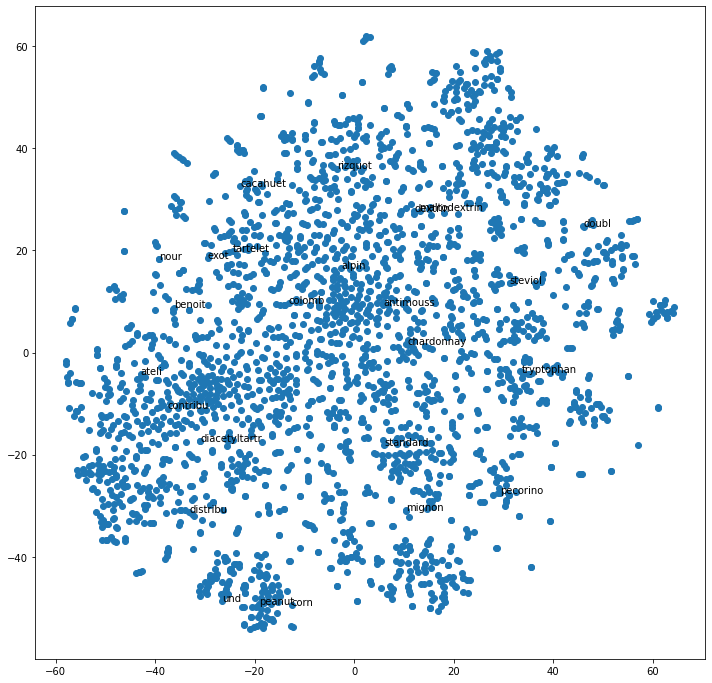

In [58]:
%%time

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_with_matplotlib(x_vals, y_vals, labels)

In [84]:
from gensim.models import word2vec

In [85]:
%%time

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(sentences=sentences, vector_size=feature_size,
                          window=window_context, min_count=min_word_count,
                          sample=sample)

CPU times: user 1min 8s, sys: 1.07 s, total: 1min 9s
Wall time: 46.2 s


In [86]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=6)]
                  for search_term in ['vin', 'viand', 'fruit', 'legum', 'fromag', 'pain', 'farin', 'sucre', 'lait']}
similar_words

{'vin': ['porto', 'cognac', 'xer', 'merlu', 'label', 'cidr'],
 'viand': ['plasm', 'halal', 'escalop', 'manchon', 'echin', 'epaul'],
 'fruit': ['frult', 'betterav', 'anthocyan', 'arachid', 'amide', 'cocoo'],
 'legum': ['poireau', 'pan', 'brocol', 'navet', 'rav', 'potimarron'],
 'fromag': ['emmental',
  'comt',
  'mozzarel',
  'garnitur',
  'pasteuris',
  'camembert'],
 'pain': ['special', 'mi', 'baguet', 'panif', 'amelior', 'viennois'],
 'farin': ['germ', 'fann', 'billet', 'fain', 'poudr', 'gluten'],
 'sucre': ['canneberg', 'cranberr', 'banan', 'frambois', 'myrtill', 'morceau'],
 'lait': ['poudr', 'laitier', 'lalt', 'lactoserum', 'permeat', 'babeurr']}

In [41]:
ingredients

defaultdict(int,
            {'eau': 108849,
             'grain': 28801,
             'tegu': 192,
             'moutard': 19269,
             'vinaigr': 22671,
             'vin': 9711,
             'roug': 12962,
             'sel': 159423,
             'sucr': 139922,
             'mout': 1106,
             'raisin': 7999,
             'oignon': 30625,
             'color': 29900,
             'extrait': 38049,
             'carott': 18114,
             'paprik': 8911,
             'huil': 90867,
             'tournesol': 44421,
             'son': 2285,
             'cet': 556,
             'uniqu': 409,
             'disponibl': 50,
             'chez': 226,
             'court': 100,
             'paill': 19,
             'antioxyd': 25067,
             'erythorbat': 2510,
             'sodium': 44564,
             'caramel': 9403,
             'origin': 27287,
             'tomat': 29621,
             'mayonnais': 788,
             'colz': 29878,
             'jaun': 10479,
   

In [42]:
sorted(ingredients.items(), key=lambda k_v: k_v[1], reverse=True)

[('sel', 159423),
 ('sucr', 139922),
 ('lait', 136125),
 ('eau', 108849),
 ('arom', 102792),
 ('ble', 98142),
 ('poudr', 97078),
 ('huil', 90867),
 ('farin', 85573),
 ('acid', 65970),
 ('naturel', 63449),
 ('cacao', 62373),
 ('oeuf', 49098),
 ('beurr', 48043),
 ('soj', 46600),
 ('amidon', 46548),
 ('sodium', 44564),
 ('tournesol', 44421),
 ('sirop', 43025),
 ('concentr', 42531),
 ('emulsifi', 42355),
 ('jus', 38936),
 ('pomm', 38533),
 ('extrait', 38049),
 ('conserv', 37035),
 ('fruit', 33524),
 ('glucos', 33366),
 ('porc', 31314),
 ('ecrem', 30928),
 ('oignon', 30625),
 ('color', 29900),
 ('colz', 29878),
 ('tomat', 29621),
 ('lecithin', 29402),
 ('gluten', 29207),
 ('epic', 29059),
 ('grain', 28801),
 ('pat', 28686),
 ('mais', 27757),
 ('origin', 27287),
 ('acidifi', 27023),
 ('citriqu', 26899),
 ('citron', 26616),
 ('de', 25342),
 ('poivr', 25219),
 ('antioxyd', 25067),
 ('crem', 24969),
 ('trac', 24761),
 ('viand', 24670),
 ('terr', 24666),
 ('ail', 24524),
 ('dextros', 23662),
 ('

In [47]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE # to visualize embeddings
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

CPU times: user 5.25 s, sys: 918 ms, total: 6.16 s
Wall time: 5.09 s


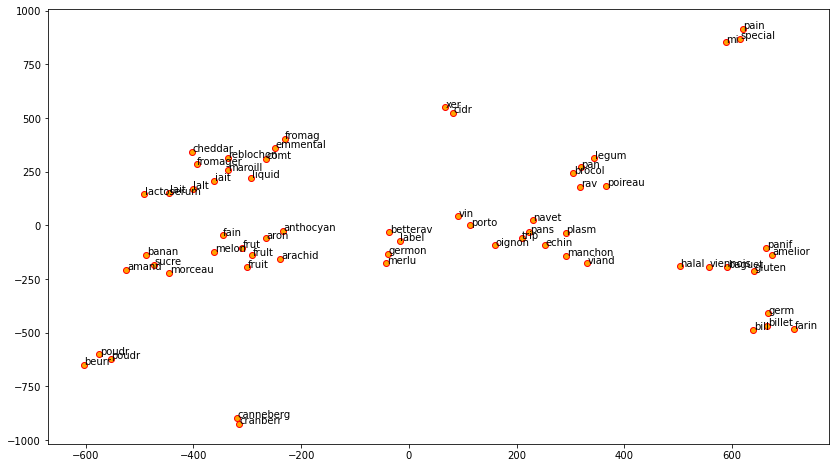

In [70]:
%%time

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels_from_tsne = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels_from_tsne, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

CPU times: user 3min 50s, sys: 7.36 s, total: 3min 58s
Wall time: 2min 36s


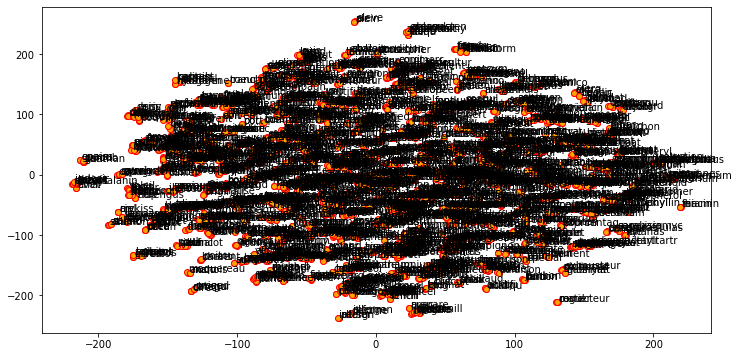

In [95]:
%%time

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(sentences=sentences, vector_size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample)

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [45]:
T

array([[  91.48859   ,   41.680874  ],
       [ 113.661125  ,    0.73248345],
       [  81.179214  ,  522.7382    ],
       [ -42.207176  , -177.45035   ],
       [  67.428894  ,  549.8102    ],
       [ -39.524544  , -132.42325   ],
       [ -17.28522   ,  -72.6652    ],
       [ 329.92657   , -177.11765   ],
       [ 208.96977   ,  -61.26918   ],
       [ 292.1649    , -143.24115   ],
       [ 291.2348    ,  -35.852707  ],
       [ 251.97446   ,  -93.37988   ],
       [ 223.18631   ,  -33.638416  ],
       [ 502.90335   , -191.12341   ],
       [-300.1431    , -195.23845   ],
       [-291.03583   , -138.83162   ],
       [ -36.269726  ,  -32.25666   ],
       [-238.49713   , -156.21185   ],
       [-233.31117   ,  -26.605663  ],
       [-265.37366   ,  -60.692287  ],
       [-309.96066   , -105.25687   ],
       [ 343.4784    ,  312.1454    ],
       [ 366.45596   ,  185.01831   ],
       [ 319.42056   ,  269.87888   ],
       [ 230.17105   ,   23.979454  ],
       [ 304.90665   ,  2

Estimated number of clusters: 10
Estimated number of noise points: 4


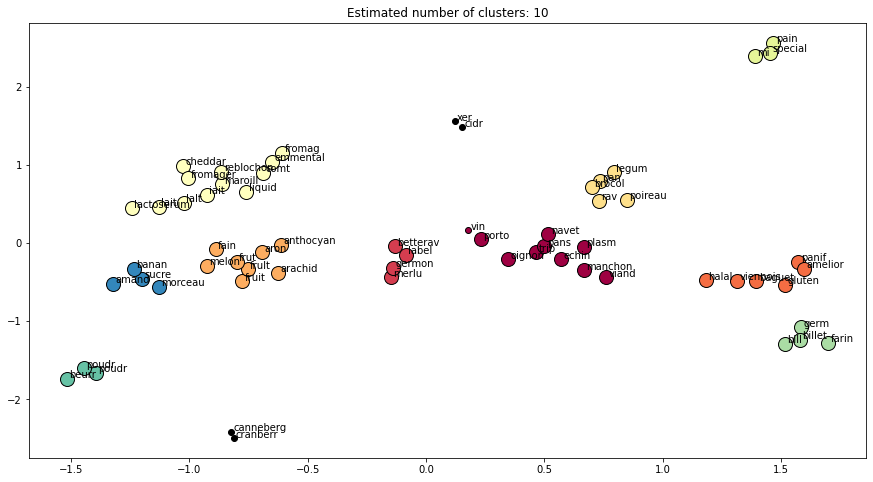

CPU times: user 904 ms, sys: 238 ms, total: 1.14 s
Wall time: 1.29 s


In [87]:
%%time

X = StandardScaler().fit_transform(T)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Plot result

plt.figure(figsize=(15, 8))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
for label, x, y in zip(labels_from_tsne, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x + 0.01, y + 0.01), xytext=(0, 0), textcoords='offset points')
plt.show()

Estimated number of clusters: 135
Estimated number of noise points: 198


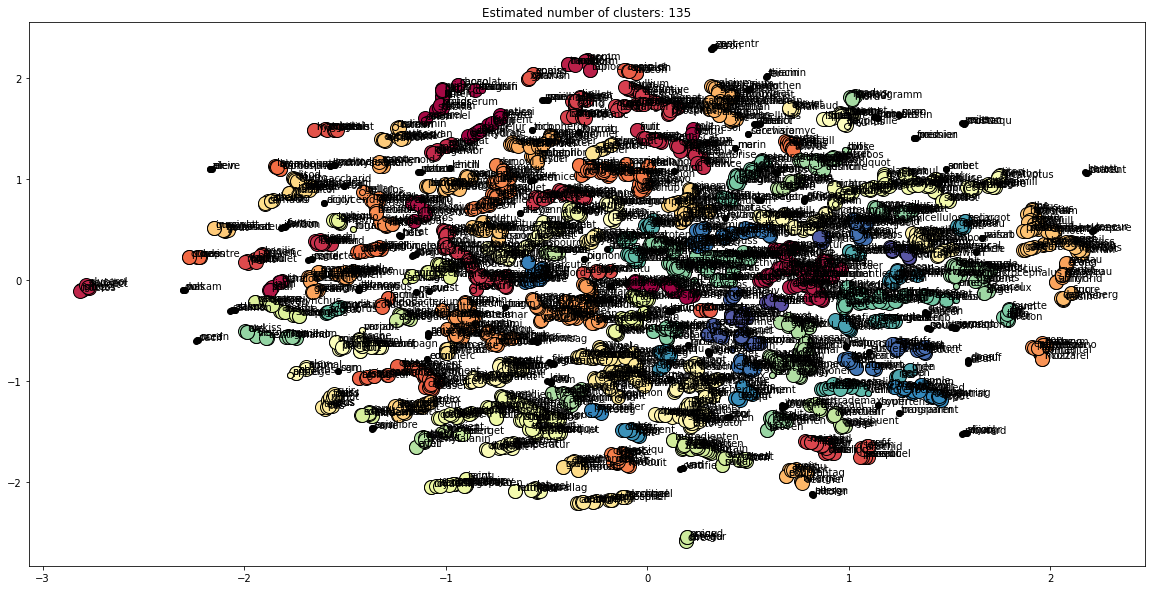

CPU times: user 4min 12s, sys: 15.2 s, total: 4min 27s
Wall time: 4min 19s


In [149]:
%%time

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(sentences=sentences, vector_size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample)

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels_from_tsne = words

X = StandardScaler().fit_transform(T)

# Compute DBSCAN
db = DBSCAN(eps=0.10, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
for label, x, y in zip(labels_from_tsne, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x + 0.01, y + 0.01), xytext=(0, 0), textcoords='offset points')
plt.show()

In [117]:
labels

array([ 8, -1,  0, ..., 85, 85, 70])

In [114]:
labels_from_tsne

['sel',
 'sucr',
 'lait',
 'eau',
 'arom',
 'ble',
 'poudr',
 'huil',
 'farin',
 'acid',
 'naturel',
 'cacao',
 'oeuf',
 'beurr',
 'soj',
 'amidon',
 'sodium',
 'tournesol',
 'sirop',
 'concentr',
 'emulsifi',
 'jus',
 'pomm',
 'extrait',
 'conserv',
 'fruit',
 'glucos',
 'porc',
 'ecrem',
 'oignon',
 'color',
 'colz',
 'tomat',
 'lecithin',
 'gluten',
 'epic',
 'grain',
 'pat',
 'mais',
 'origin',
 'acidifi',
 'citriqu',
 'citron',
 'de',
 'poivr',
 'antioxyd',
 'crem',
 'trac',
 'viand',
 'terr',
 'ail',
 'dextros',
 'vegetal',
 'gomm',
 'protein',
 'blanc',
 'franc',
 'contient',
 'vinaigr',
 'levur',
 'epaiss',
 'riz',
 'vanill',
 'biolog',
 'chocolat',
 'enti',
 'gras',
 'stabilis',
 'moutard',
 'ferment',
 'pure',
 'frais',
 'coqu',
 'carott',
 'carbonat',
 'ingredient',
 'oliv',
 'lev',
 'agricultur',
 'lactiqu',
 'palm',
 'conten',
 'potassium',
 'cann',
 'noir',
 'acidit',
 'peut',
 'alcool',
 'lactos',
 'modif',
 'malt',
 'noix',
 'roug',
 'aromat',
 'bas',
 'celer',
 'ascorb

In [146]:
ingredients_by_cluster = {cluster:[] for cluster in unique_labels}

In [147]:
for i in range(len(labels)):
    ingredients_by_cluster[labels[i]].append(labels_from_tsne[i])

In [148]:
ingredients_by_cluster

{0: ['sel',
  'epic',
  'dextros',
  'dont',
  'plant',
  'deshydrat',
  'gelatin',
  'fume',
  'saccharos',
  'fondu',
  'font',
  'triphosphat',
  'polyphosphat',
  'transforme',
  'euchem'],
 1: ['lait',
  'poudr',
  'beurr',
  'ecrem',
  'pat',
  'protein',
  'enti',
  'lactos',
  'noiset',
  'amand',
  'lactoserum',
  'pepit',
  'patissi',
  'eclat'],
 2: ['eau',
  'amidon',
  'pomm',
  'mais',
  'terr',
  'modif',
  'fecul',
  'transform',
  'fibr',
  'maltodextrin',
  'tapioc',
  'manioc',
  'cuisin',
  'barbecu',
  'texture'],
 3: ['arom',
  'naturel',
  'color',
  'stabilis',
  'gelifi',
  'caramel',
  'miel',
  'caramelis',
  'rhum',
  'mel'],
 4: ['ble', 'farin', 'levur', 'froment', 'crep', 'dentel'],
 5: ['acid', 'acidifi', 'citriqu', 'ascorb', 'maliqu'],
 6: ['cacao', 'emulsifi', 'lecithin', 'chocolat', 'maigr'],
 7: ['oeuf', 'blanc', 'jaun', 'vin', 'echalot', 'poul', 'sol'],
 8: ['soj',
  'minimum',
  'pur',
  'vanillin',
  'anhydr',
  'laitier',
  'mass',
  'degraiss',
 


Clustering sur les ingrédients afin de découvrir les catégories d'ingrédients. Après avoir réalisé le word embbeding grâce à la library gensim, on a testé le DBSCAN, qui est un algorithme qui regroupe les grappes en fonction de la densité du nuages de point. Il est très intéressant car il prend en considération le bruit contrairement à d'autres algorithmes. 
On découvre ainsi plusieurs catégories d'ingrédients. 

On a :
_les viandes (14: ['porc', 'viand', 'canard', 'boeuf', 'foi', 'bouillon', 'volaill', 'bovin', 'couen', 'veau'])
_les fruits de mer (64: ['crevet', 'etou', 'moul', 'lieu', 'surim', 'encornet', 'merlu', 'calmar', 'ge', 'indien', 'spp', 'mytilus', 'anneau', 'decoquille', 'limand'])  
_les fromages (36: ['fromag', 'emmental', 'mozzarel', 'rap', 'ricott', 'lysozym', 'parmesan', 'gran', 'padano', 'reggiano', 'parmigiano'])  
_les légumes (15: ['oignon', 'carott', 'roug', 'vert', 'sauc', 'poivron', 'legum', 'pois', 'poireau', 'deshydrate', 'haricot', 'courget', 'menth', 'petit', 'epinard', 'feuill', 'chich', 'aubergin', 'grill', 'assaison', 'rehydrate', 'chou', 'essentiel', 'prefrit', 'frit', 'navet', 'rav', 'pouss', 'pan', 'choux', 'bambou', 'brocol', 'citronnel', 'mungo'])  
_les fruits (30: ['pure', 'bas', 'pectin', 'frambois', 'abricot', 'pulp', 'pech', 'anan', 'cass', 'ceris', 'mangu', 'banan', 'poir', 'myrtill', 'concentre', 'passion', 'sureau', 'mur', 'groseil', 'griott'])  
_les épices (11: ['extrait', 'aromat', 'paprik', 'piment', 'curcum', 'coriandr', 'romarin', 'gingembr', 'cumin'])  
_etc...

Mais aussi la façon dont sont préparés les aliments (88: ['minut', 'votr', 'four', 'pend', 'vos', 'cuir', 'laiss'])
(90: ['decongel', 'recongel', 'fait', 'capsul', 'pouv', 'eur', 'pret', 'contenu', 'ideal', 'bouill', 'emb', 'dessous', 'deux', 'rep', 'ains', 'evit', 'suiv', 'moment', 'journe', 'mettr', 'doivent', 'local', 'retrouv', 'il', 'assur', 'adapt', 'ebullit', 'het', 'recycl', 'consign'])

Il y a aussi les nutriments, les éléments chimiques et encore d'autres, la liste est longue.

In [ ]:
%%time

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(sentences=sentences, vector_size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample)

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

In [159]:
w2v_words = w2v_model.wv.index_to_key
w2v_vectors = w2v_model.wv[words]
w2v_indices = w2v_model.wv.key_to_index

In [229]:
def vectorize(line): 
    words = []
    for word in line: # line - iterable, for example list of tokens 
        try:
            w2v_idx = w2v_indices[word]
        except KeyError: # if you does not have a vector for this word in your w2v model, continue 
            continue
        words.append(w2v_vectors[w2v_idx])
        if words: 
            words = np.asarray(words)
            min_vec = words.min(axis=0)
            max_vec = words.max(axis=0)
            return np.concatenate((min_vec, max_vec)).tolist()
        if not words:
            return None 

In [255]:
%%time

product_vectors = []
for word in sentences:
    product_vectors.append(vectorize(word))

CPU times: user 2.96 s, sys: 574 ms, total: 3.53 s
Wall time: 3.92 s


In [302]:
#np.array(product_vectors, dtype='float32')

In [ ]:
len(product_vectors)

In [253]:
w2v_model.wv[words][0:5]

array([[ 1.5148258 ,  0.6973309 ,  6.3817263 ,  0.19258346,  1.9927286 ,
        -4.633813  ,  6.090459  ,  2.470829  , -1.8206862 , -3.004543  ],
       [ 1.2242541 , -3.6819394 ,  2.9297016 , -2.4220173 ,  3.8812802 ,
         4.645136  ,  4.0548596 , -0.501222  , -7.410733  , -0.56755006],
       [ 0.6502463 , -5.4632907 ,  8.253444  , -4.517564  ,  3.621159  ,
         3.7361329 ,  3.9040842 ,  3.7907453 , -0.5388458 ,  1.7970589 ],
       [-0.11874258, -3.0315917 ,  2.8701227 ,  1.0245378 ,  0.43760574,
        -3.9938655 ,  5.317039  , -2.9213133 , -3.6865735 , -2.15345   ],
       [-2.018945  ,  2.3275273 ,  4.004505  , -3.4152563 ,  1.7180706 ,
         2.744908  ,  3.9703012 ,  6.331334  , -4.8632555 , -3.0974667 ]],
      dtype=float32)

In [283]:
np.array(product_vectors[0:2100], dtype='float32')

array([[-0.11874258, -3.0315917 ,  2.8701227 , ..., -2.9213133 ,
        -3.6865735 , -2.15345   ],
       [-5.0370445 ,  3.645985  ,  1.8237375 , ...,  4.1870184 ,
        -0.99504083, -8.097157  ],
       [ 0.7173856 ,  0.02585191, -0.40974876, ..., -1.6741138 ,
         0.95061666, -0.05174094],
       ...,
       [ 5.535362  , -0.04425515,  5.450084  , ..., -2.588927  ,
        -7.3376684 , -0.45108527],
       [ 6.552693  , -2.4111438 ,  5.4604254 , ..., -3.854781  ,
        -1.1547066 , -2.4866495 ],
       [ 6.552693  , -2.4111438 ,  5.4604254 , ..., -3.854781  ,
        -1.1547066 , -2.4866495 ]], dtype=float32)

CPU times: user 4min 16s, sys: 12 s, total: 4min 28s
Wall time: 2min 53s


/Users/macvysion/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127815 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/macvysion/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127815 missing from current font.
  font.set_text(s, 0, flags=flags)


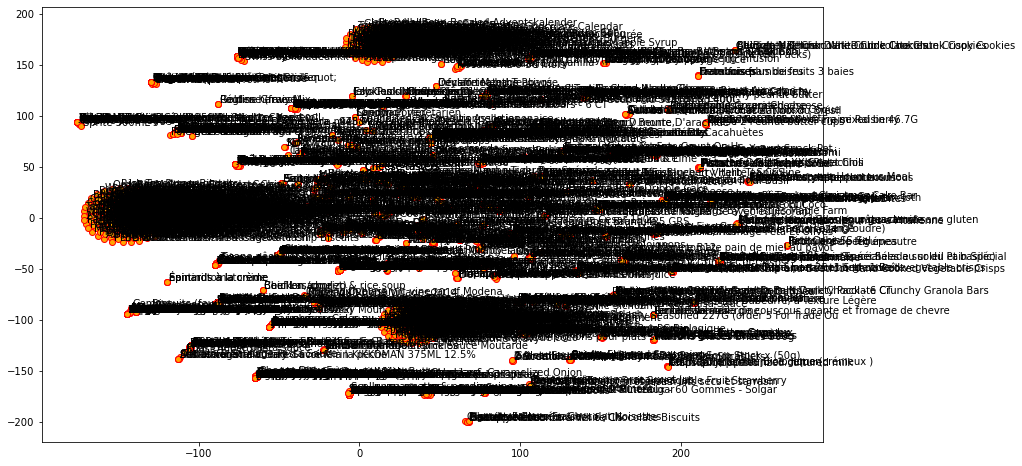

In [284]:
%%time

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(np.array(product_vectors[0:2100], dtype='float32'))
labels_from_tsne = fr_db2["product_name"].values

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels_from_tsne, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

CPU times: user 28.9 ms, sys: 2.82 ms, total: 31.8 ms
Wall time: 35.2 ms


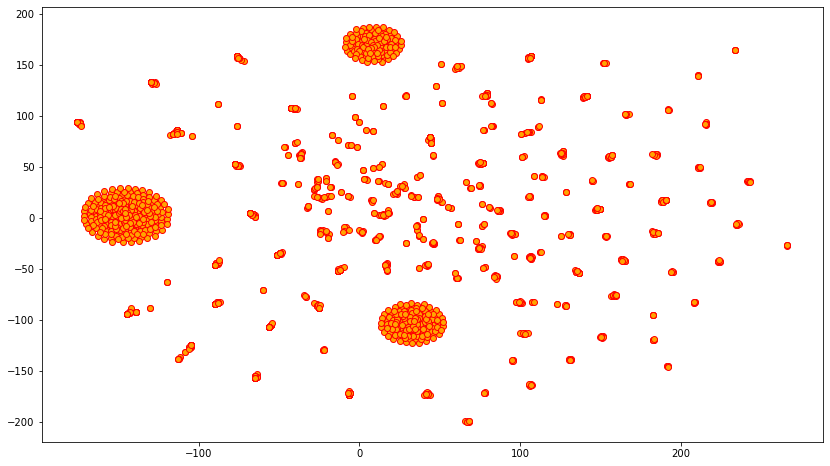

In [285]:
%%time

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
#for label, x, y in zip(labels_from_tsne, T[:, 0], T[:, 1]):
#    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Estimated number of clusters: 88
Estimated number of noise points: 93


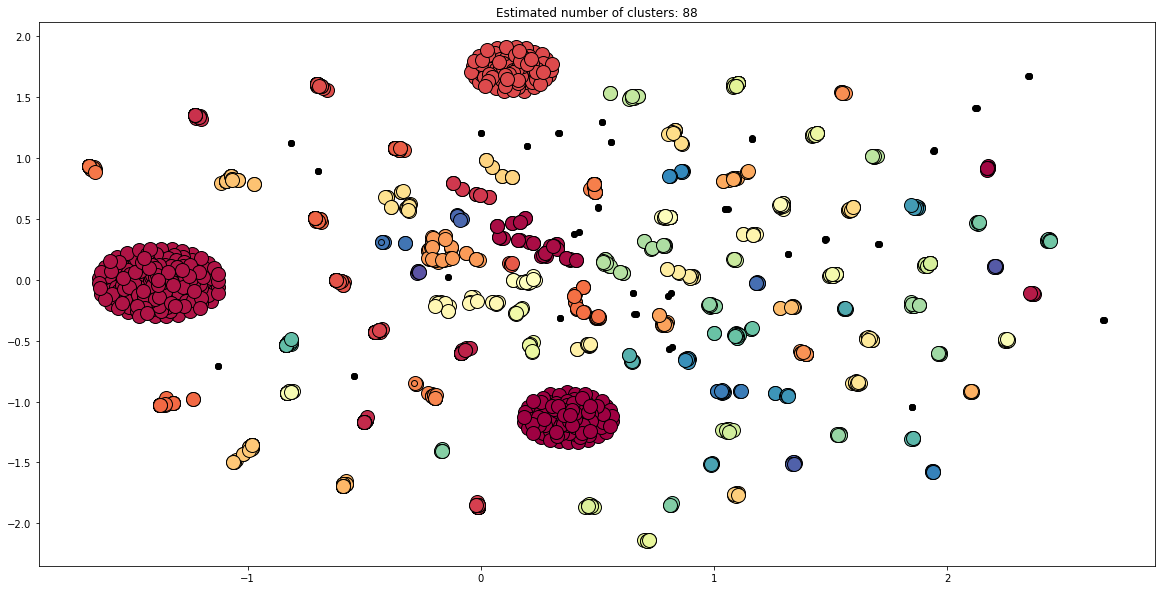

CPU times: user 615 ms, sys: 55.2 ms, total: 670 ms
Wall time: 983 ms


In [286]:
%%time

X = StandardScaler().fit_transform(T)

# Compute DBSCAN
db = DBSCAN(eps=0.10, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
#for label, x, y in zip(labels_from_tsne, X[:, 0], X[:, 1]):
#    plt.annotate(label, xy=(x + 0.01, y + 0.01), xytext=(0, 0), textcoords='offset points')
plt.show()

In [289]:
product_by_cluster = {cluster:[] for cluster in unique_labels}

In [290]:
for i in range(len(labels)):
    product_by_cluster[labels[i]].append(labels_from_tsne[i])

In [291]:
product_by_cluster

{0: [' moutarde au moût de raisin ',
  'Root Beer',
  'A&w - Root Beer - 355ml',
  'Pepsi, Nouveau goût !',
  'Blle Pet 50CL Coca Cola Cherry',
  '7Up',
  'Pain de mie sans gluten',
  '2 MINI BAGUETTES SANS GLUTEN',
  'tortellini 4 fromages sauce crème',
  'Yorkshire Gold',
  'Iced Tea Spanish Peach',
  'Tarte citron meringuée',
  "Pur Soup' Velouté de légumes",
  'Conference Pears',
  'Mirin type',
  'Agua fresca watermelon & lime',
  'Ramune',
  'Mtn dew kick start energizing fruit punch',
  'Hoptimista',
  'Boisson au soja',
  'Almond drink',
  'Sopa de tomate y albahaca',
  'Dr Pepper Cherry Vanilla',
  'Lychee au sirop',
  'Préparation à base de lait de coco',
  'Boisson à base de jus de mangue',
  'Boisson à base de jus de lychee',
  'Frozen Spring Roll Pastry',
  'Jus De Litchi Panchy 250ML 0',
  'Jus De Goyave',
  'Frozen sesame ball',
  'Lychee drink',
  'Sauce Aigre Douce 720 ML',
  'Sauce Aigre Douce 280ML',
  'Soupe Tom Yum aux légumes',
  'Boisson a base de jus de lychee',

On voit clairement apparaitre 3 gros clusters d'aliments sur les 2100 premiers produits :

_les desserts ou tout ce qui est sucreries: (11: ['Entremets Crème Brulée', 'Coeurs chocolat tte couleur', 'Biscuits sablés fourrage au cacao', 'Glaçage fondant', 'Pâte à Sucre', "M&M's Peanut Butter", "Duerr's Marmelade Morceaux Fins Orange", 'bijou', 'Financiers aux Amandes', 'Fondants Citron', 'Moelleux au chocolat', 'All Butter Fruity Flapjack Cookies', 'Paupiette de volaille sauce forestière brocolis purée', 'Fizzy pop sweets', 'Tarte passion meringuée', 'After Dinner', 'Lemon meringue fudge', 'Dolly Mixtures', 'Full of beans', 'Fizzy whizzy Cola Bottles', 'Chocolat noir roasted hazelnut', 'Lemon Drizzle Cake', etc)  
_tout ce qui est à base de pain (sandwich etc...): (7: ['Sandwich solene céréales sicilien','Burger USA','Baguette Parisien','Baguette Lyonnais','Club Crudités','Baguette poulet','Club Turkey Bacon','Bagnat thon','Bagel sésame 3 fromages','Triangle Crudités','Baguette Niçois','Ciabatta Rôti de porc BBQ','Ciabatta Rôti de porc moutarde','Ciabatta Vietnamien','Suédois Thon','baguette Poitevin','Bagel Légume grillés','Baguette Brie &quot;Petit Prix&quot;','Sandwich poulet rôti','Wholemeal seeded farmhouse','Maxi Burger charolais','spécial sandwich complet','Tartines de Pain Blé Complet','WholeMeal Bread'],)  
_les thés : (16: ['Thé noir aromatisé violette et fleurs', 'Thé de Noël aromatisé orange-cannelle', 'Thé noir Assam bio', 'Matcha Green Teabags', 'Earl grey green teabags', 'Ahmad Tea - English Breakfast 50 Bags - 125G', 'Thé vert au Jasmin Twinings', 'Thé citron intense', 'Thé original earl grey', 'Jasmin Oriental', 'Thé Darjeeling', 'Original Earl Grey', 'Thé vanille', 'Thé Orange Cannelle', 'Lady grey Goût russe', 'Orangery Of Lady Grey', 'Summer Berry Green Tea', 'Gunpowder thé vert nature', 'Twinings Thé vert menthe', 'Thé', 'Orangery of Lady Grey', 'Russin Earl Grey', 'Création thé vert rose et menthe', 'Twinings fresh thé vert menthe', 'Twinings fresh thé vert citron', 'thé vert nature bio en sachets', 'Empress grey teabags'])  
Les sauces à base de tomate_ : (34: ['Sauce Tomate Aux Champignons Bio Kazidomi', 'Sauce Tomate Puttanesca Bio Kazidomi', 'Sauce Tomate Aux Courgettes Bio Kazidomi', 'Sauce Tomate Au Thon & Olives Bio Kazidomi', 'Sauce tomate aux légumes bio Kazidomi', 'Red Pesto', 'Purée tomates tradition aux oignons crus', 'Purée Tradition aux oignons crus', 'Fufu', 'Tomato Ketchup', 'Sauce Tomate et Pesto', 'Truffle ketchup']  
_etc...

CPU times: user 7.88 s, sys: 1.43 s, total: 9.32 s
Wall time: 15.2 s


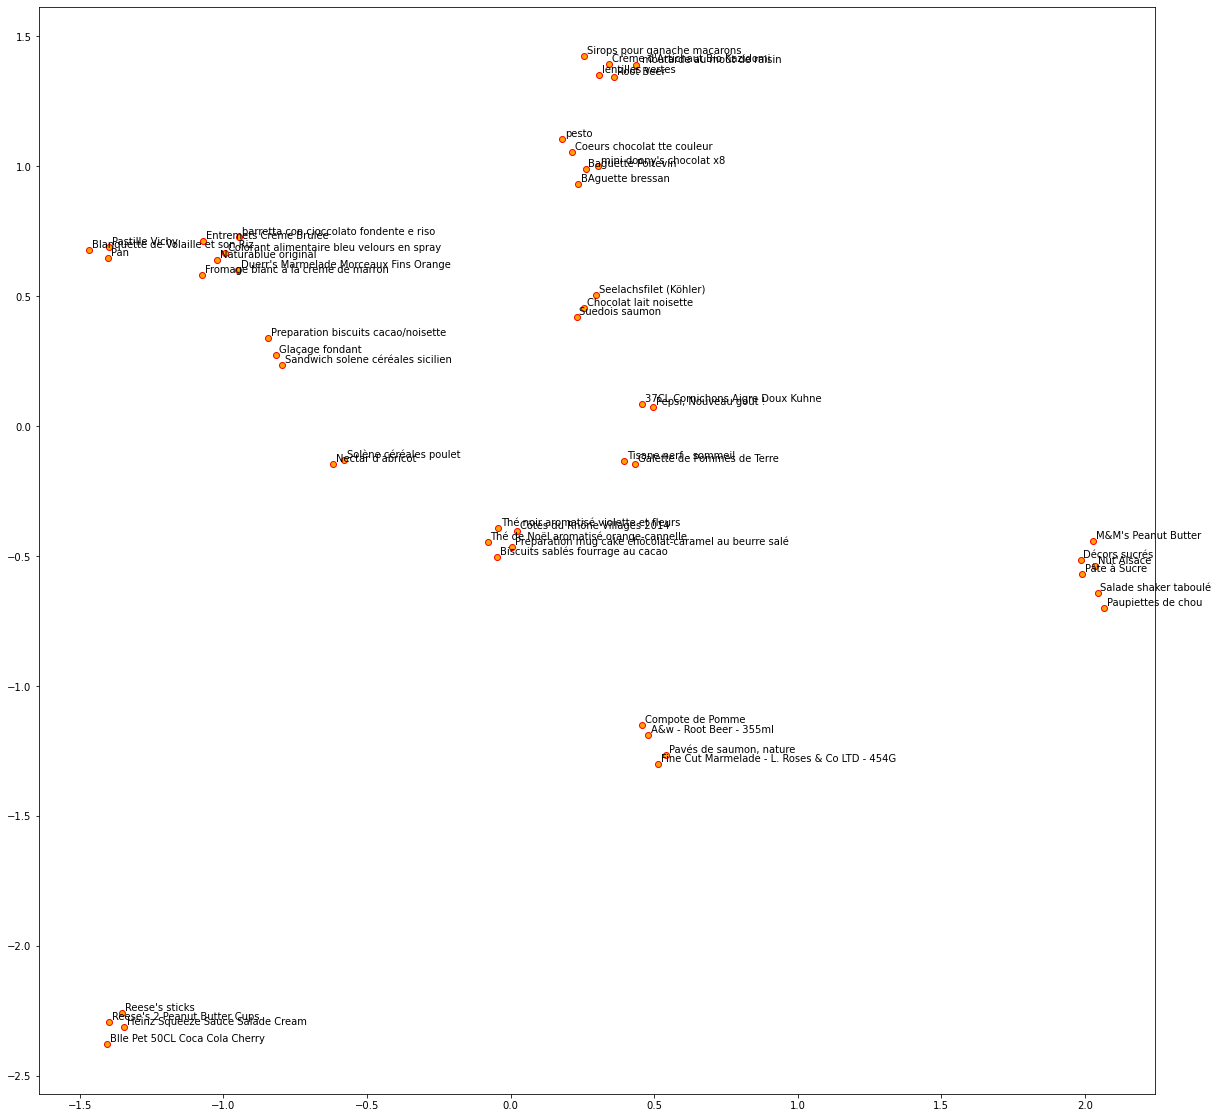

In [301]:
%%time

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(np.array(product_vectors[250:300], dtype='float32'))
labels_from_tsne = fr_db2["product_name"].values

T = StandardScaler().fit_transform(T)

plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels_from_tsne, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+0.01, y+0.01), xytext=(0, 0), textcoords='offset points')